In [14]:
import yfinance as yf
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


class MyARIMA:
    sc_in = MinMaxScaler(feature_range=(0, 1))
    sc_out = MinMaxScaler(feature_range=(0, 1))

    def __init__(self, args):
        self.train_size = -1
        self.test_size = -1
        self.order = tuple(map(int, args.order.split(', ')))

    def fit(self, data_x):
        data_x = np.array(data_x)
        train_x = data_x[:, 1:-1]  # Exclude the 'Date' and 'Next_Close' column
        train_y = data_x[:, -1]
        self.train_size = train_x.shape[0]
        train_x = self.sc_in.fit_transform(train_x)
        train_y = train_y.reshape(-1, 1)
        train_y = self.sc_out.fit_transform(train_y)
        train_x = np.array(train_x, dtype=float)
        train_y = np.array(train_y, dtype=float).flatten()
        self.model = ARIMA(train_y, exog=train_x, order=self.order)
        self.result = self.model.fit()

    def predict_future(self, test_x, steps=4):
        # Użyj danych testowych na 4 dni, aby dopasować do liczby kroków
        test_x = np.array(test_x[["Open", "High", "Low", "Volume"]], dtype=float)[:steps]  # Use only `steps` rows
        test_x = self.sc_in.transform(test_x)  # Scale the test features

        # Predict future prices using ARIMA model
        future_preds = self.result.forecast(steps=steps, exog=test_x)

        # Reshape and inverse transform the predictions to get them back to the original scale
        future_preds = future_preds.reshape(-1, 1)
        future_preds = self.sc_out.inverse_transform(future_preds)
        return future_preds

In [15]:
# Define the stock ticker and period
ticker = 'BTC-USD'  # Apple Inc.

# Fetch data
data = yf.download(ticker, start="2021-01-01", end="2023-12-31")
data.reset_index(inplace=True)  # Ensure 'Date' is a column


[*********************100%***********************]  1 of 1 completed


In [16]:
# Create 'Next_Close' column
data['Next_Close'] = data['Close'].shift(-1)

# Drop the last row as it contains NaN in 'Next_Close'
data.dropna(inplace=True)

# Select relevant columns
data_selected = data[['Date', 'Open', 'High', 'Low', 'Volume', 'Next_Close']]

# Convert to NumPy array
data_array = data_selected.to_numpy()


In [17]:
from argparse import Namespace

# Define ARIMA order
args = Namespace(order='6, 0, 0')

# Initialize the model
model = MyARIMA(args)

# Fit the model
model.fit(data_array)


C:\Users\Michał\Desktop\crypto\venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [22]:
# Fetch the latest data for prediction

test_data = yf.download(ticker, start="2024-01-01", end="2024-12-31")
test_data.reset_index(inplace=True)
test_data_selected = test_data[['Open', 'High', 'Low', 'Volume']]
print(test_data)
# Make sure we have at least 4 days of data
# if test_data_selected.shape[0] < 8:
#     raise ValueError("Not enough data for prediction steps.")

# Predict future prices
future_predictions = model.predict_future(test_data_selected, steps=len(test_data))

# Display predictions
print("Future Predictions:")
print(len(future_predictions))


[*********************100%***********************]  1 of 1 completed


          Date          Open          High           Low         Close  \
0   2024-01-01  42280.234375  44175.437500  42214.976562  44167.332031   
1   2024-01-02  44187.140625  45899.707031  44176.949219  44957.968750   
2   2024-01-03  44961.601562  45503.242188  40813.535156  42848.175781   
3   2024-01-04  42855.816406  44770.023438  42675.175781  44179.921875   
4   2024-01-05  44192.980469  44353.285156  42784.718750  44162.691406   
..         ...           ...           ...           ...           ...   
284 2024-10-11  60275.460938  63400.871094  60046.125000  62445.089844   
285 2024-10-12  62444.617188  63448.785156  62443.269531  63193.023438   
286 2024-10-13  63192.945312  63272.652344  62035.636719  62851.375000   
287 2024-10-14  62848.398438  66482.492188  62442.152344  66046.125000   
288 2024-10-15  66064.085938  67692.656250  64953.996094  66585.335938   

        Adj Close       Volume  
0    44167.332031  18426978443  
1    44957.968750  39335274536  
2    42848.1

ValueError: Provided exogenous values are not of the appropriate shape. Required (365, 4), got (289, 4).

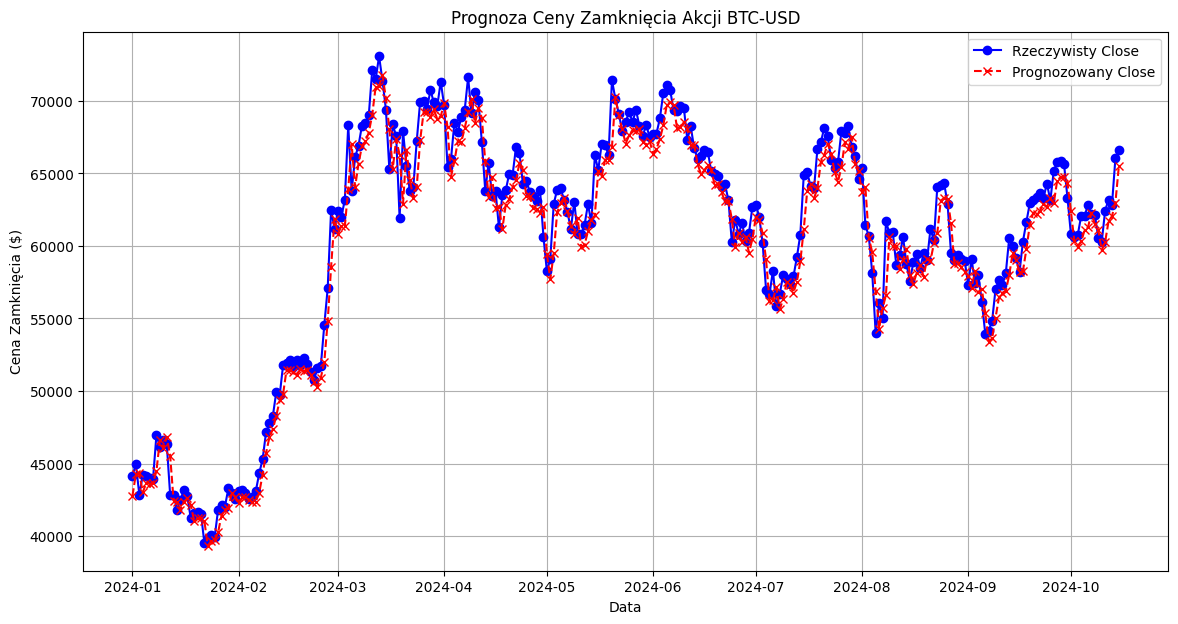

In [19]:
plt.figure(figsize=(14,7))

# Plot rzeczywistych kursów zamknięcia z test_data
plt.plot(test_data['Date'], test_data['Close'], label='Rzeczywisty Close', marker='o', linestyle='-', color='blue')

# Plot prognozowanych kursów zamknięcia
plt.plot(test_data['Date'], future_predictions, label='Prognozowany Close', marker='x', linestyle='--', color='red')

# Dodanie tytułu i etykiet
plt.xlabel('Data')
plt.ylabel('Cena Zamknięcia ($)')
plt.title(f'Prognoza Ceny Zamknięcia Akcji {ticker}')
plt.legend()
plt.grid(True)
plt.show()
